In [57]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../code/python')
from mpl_settings_v3 import *

In [38]:
def solver(f, k, ti, tf, x0, method='RK4'):
    time = np.arange(0, T+k, k)
    x = x0
    data = [x]
    for i, t in enumerate(time[1:]):

        if method == 'euler':
            x = x + k * f(x, t)
        elif method == 'RK4':
            q1 = f(x, t)
            q2 = f(x + (k/2)*q1, t+(k/2))
            q3 = f(x + (k/2)*q2, t+(k/2))
            q4 = f(x + k*q3, t+k)
            x = x + (k/6)*(q1 + 2*q2 + 2*q3 + q4) 

        data.append(x)

    data = np.array(data)
    return time, data

def QtildeTest(f, k, a, b, y0, method='euler'):
    
    """

    Compute precision quotient \tilde{Q}, defined as 

    \tilde{Q}(t) = ( v_1(t,k) - y(t) ) / ( v_2(t, k/2) - y(t) ).

    Ref. Kreiss-Ortiz, p. 33.

    """

    time,  data  = solver(f, k, a, b, y0, method)
    time2, data2 = solver(f, k/2, a, b, y0, method)
    time3, data3 = solver(f, k/4, a, b, y0, method) 
    
    v  = data[:,0]
    v2 = data2[:,0]
    v3 = data3[:,0]
    
    num   = v - v2[::2]
    denom = (v2 - v3[::2])[::2]
    
    Q = num / denom
    
    return time, Q

from scipy.stats import linregress
def getLinearReg(sizes, values, mode='logXY', return_intercept=False):
    
    if mode == 'logXY':
        X = np.log(sizes)
        Y = np.log(values)
    elif mode == 'logX':
        X = np.log(sizes)
        Y = np.array(values)
    elif mode == 'logY':
        X = np.array(sizes)
        Y = np.log(values)
    else:
        X = np.array(sizes)
        Y = np.array(values)
   
    slope, intercept, r_value, p_value, slope_err = linregress(X, Y)
    r2 = r_value**2
    Y_pred = intercept + X*slope
    
    if mode in ['logY', 'logXY']:
        Y_pred = np.exp(Y_pred)
    if return_intercept:
        return Y_pred, slope, slope_err, r2, intercept
    else:
        return Y_pred, slope, slope_err, r2

In [6]:
omega = 1
def f(x, t):
    return np.array([omega*x[1], -omega*x[0]])
    
def energy(data):
    return np.linalg.norm(data, axis=1)
    
x0 = (1, 0)
T = 100
k = 0.01
methods = ['euler', 'RK4']
data = {}
Q_data = {}
for method in methods:
    time, sol = solver(f, k, 0, T, x0, method)
    data[method] = [time, sol]
    
    Qtime, Q = QtildeTest(f, k, 0, T, x0, method=method)
    Q_data[method] = [Qtime, Q]

/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


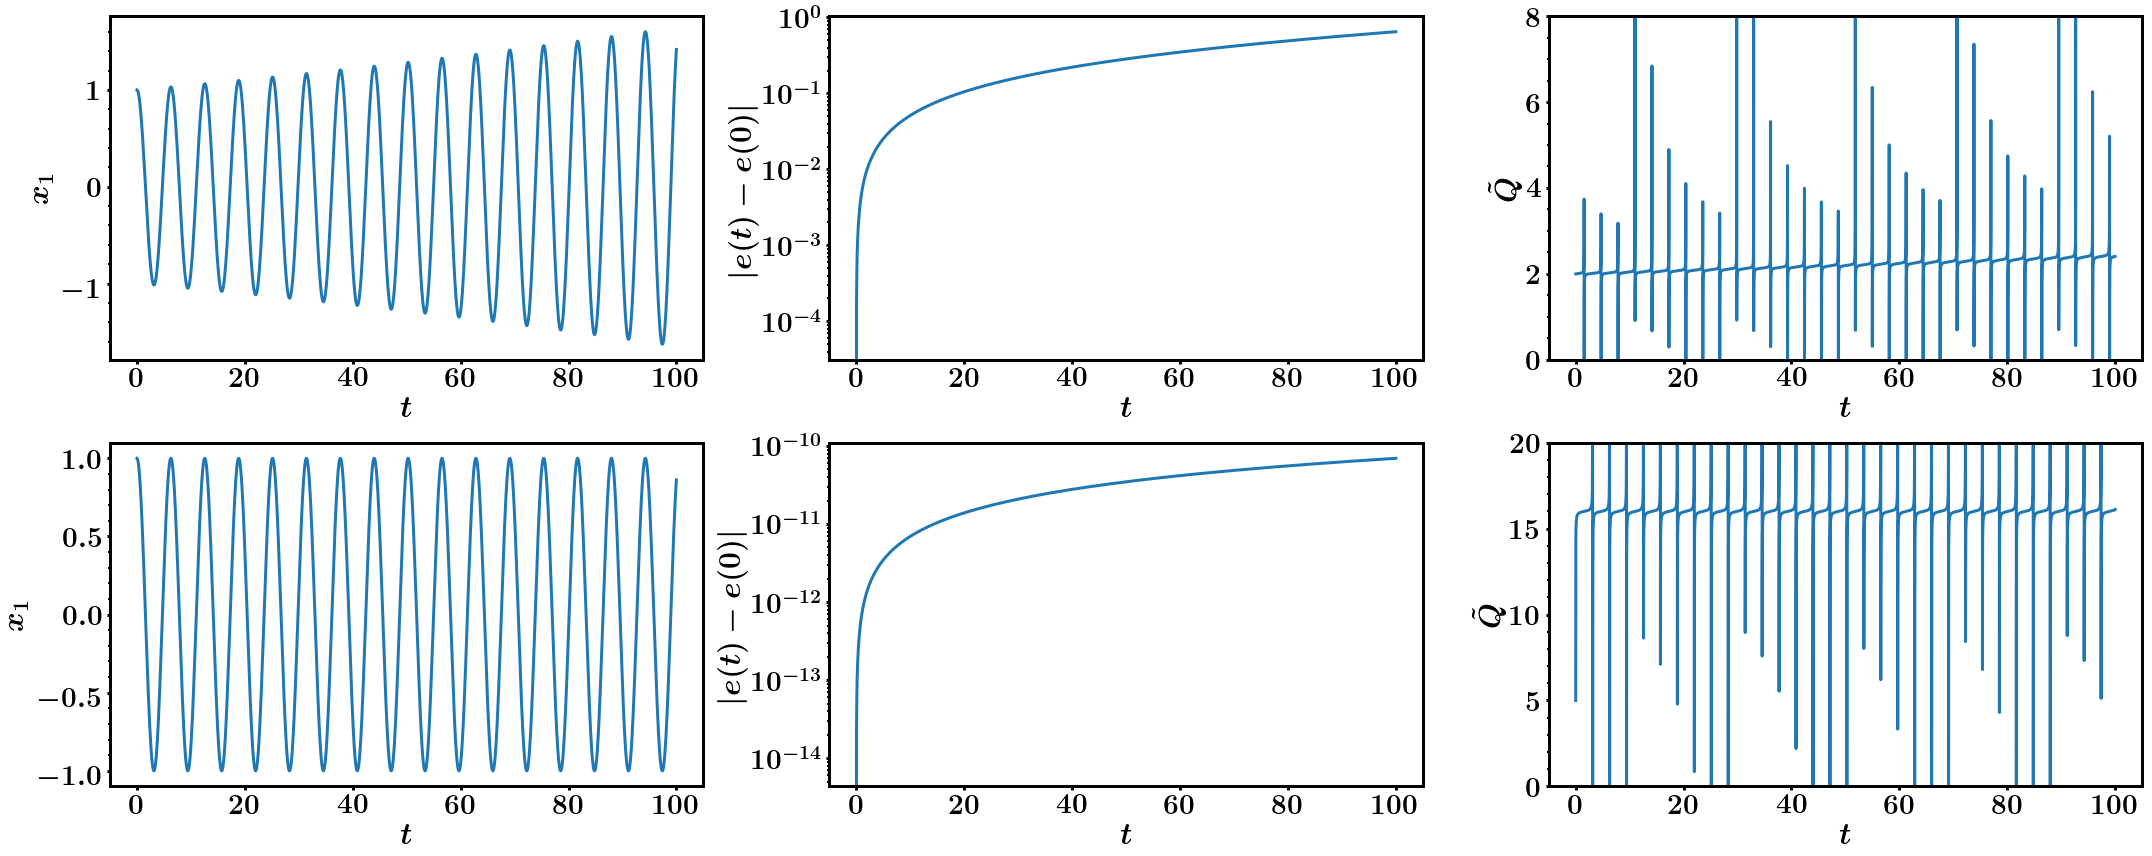

In [76]:
ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, method in enumerate(methods):
    time, x = data[method]
    x1 = x[:,0]
    e = energy(x)
    Qtime, Q = Q_data[method]
    
    ax = axes[i][0]
    ax.set_ylabel(r'$x_1$')
    ax.plot(time, x1)
    #ax.plot(time, data[:,1])

    ax = axes[i][1]
    ax.set_yscale('log')
    ax.set_ylabel(r'$|e(t) - e(0)|$')
    ax.plot(time, np.abs(e-1))
    
    ax = axes[i][2]
    ax.set_ylabel(r'$\tilde{Q}$')
    if method == 'euler':
        ax.set_ylim(0, 8)
    else:
        ax.set_ylim(0, 20)
    ax.plot(Qtime, Q)
    
plt.tight_layout()
plt.show()

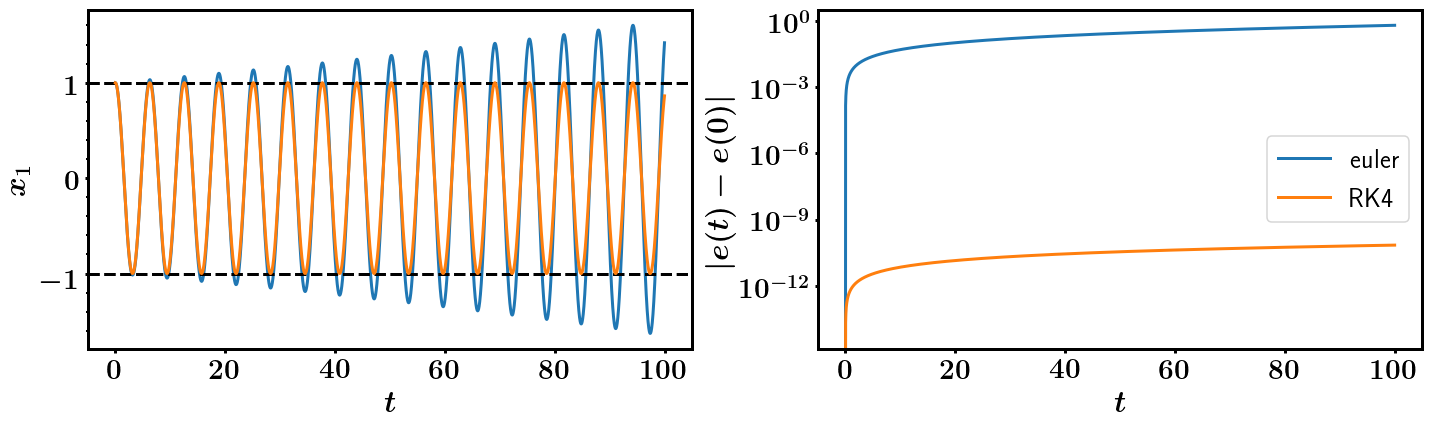

In [15]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, method in enumerate(methods):
    time, x = data[method]
    x1 = x[:,0]
    e = energy(x)
    Qtime, Q = Q_data[method]
    
    ax = axes[0]
    ax.axhline(1, linestyle='--', color='k')
    ax.axhline(-1, linestyle='--', color='k')
    ax.set_ylabel(r'$x_1$')
    ax.plot(time, x1)
    
    #ax.plot(time, data[:,1])

    ax = axes[1]
    ax.set_yscale('log')
    ax.set_ylabel(r'$|e(t) - e(0)|$')
    ax.plot(time, np.abs(e-1), label=method)
    ax.legend(loc=5)
    
plt.tight_layout()
plt.savefig('./informe/figures/oscilador.png')
plt.show()

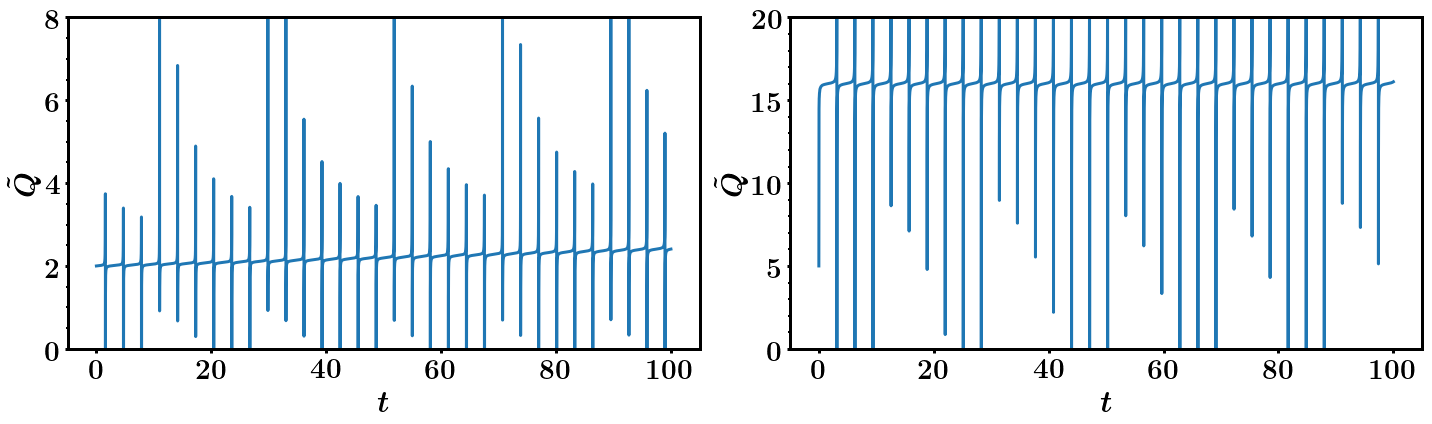

In [16]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, method in enumerate(methods):
    time, x = data[method]
    x1 = x[:,0]
    e = energy(x)
    Qtime, Q = Q_data[method]
    
    ax = axes[i]
    ax.set_ylabel(r'$\tilde{Q}$')
    if method == 'euler':
        ax.set_ylim(0, 8)
    else:
        ax.set_ylim(0, 20)
    ax.plot(Qtime, Q)
    
plt.tight_layout()
plt.savefig('./informe/figures/orden.png')
plt.show()

In [33]:
x0 = (1, 0)
T = 100
energy_values = []
k_values = np.logspace(-5, -2, 6)
for k in k_values:
    time, sol = solver(f, k, 0, T, x0, 'euler')
    e = energy(sol)
    energy_values.append(np.abs(e[-1]-1))

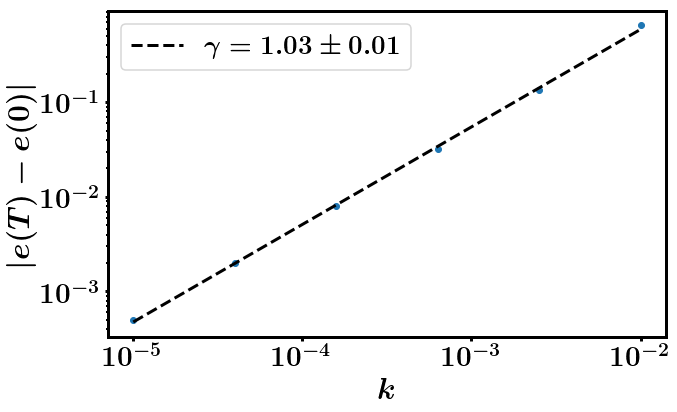

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$k$')
ax.set_ylabel(r'$|e(T)-e(0)|$')
ax.plot(k_values, energy_values, 'o')

Y_pred, slope, y_err, r2 = getLinearReg(k_values, energy_values)
ax.plot(k_values, Y_pred, label=r'$\gamma={{{:.2f}}}\pm {{{:.2f}}}$'.format(slope, y_err),
       linestyle='--', color='k')

ax.legend()
plt.savefig('./informe/figures/convergencia.png')
plt.show()

In [80]:
def f(X, t):
    
    x, y, vx, vy = X
    
    fx = [
        vx,
        vy,
        -x/(x**2+y**2)**(3/2),
        -y/(x**2+y**2)**(3/2)
    ]
    
    return np.array(fx)

def energy(data, polar=True):
    
    if polar:
        r, phi, vr, vphi = data
        return np.NaN
    x, y, vx, vy = data[:,0], data[:,1], data[:,2], data[:,3]
    return 0.5*(vx**2+vy**2) - 1/np.sqrt(x**2+y**2)

def radius(data):
    return np.sqrt(data[:,0]**2 + data[:,1]**2)
    
T = 1000
k = 0.01
method = 'RK4'
v_values = [0.5, 1, 1.2, 1.3, 1.4, 1.5, 1.6]
data = {}
Q_data = {}
for v in v_values:
    print(v)
    X0 = (1, 0, 0, v)
    time, sol = solver(f, k, 0, T, X0, method)
    data[v] = [time, sol]

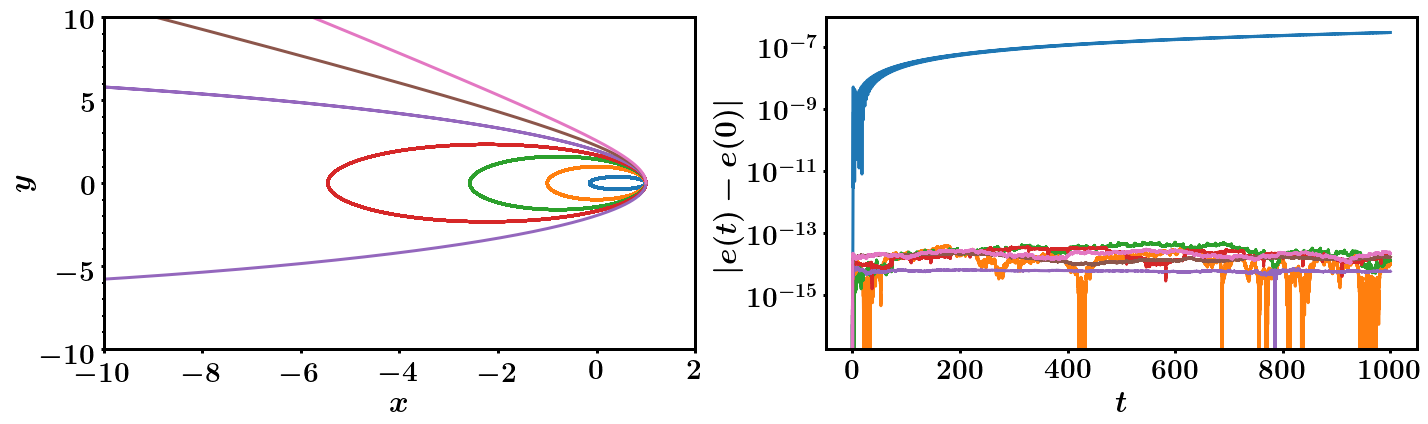

In [76]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, v in enumerate(v_values):
    time, X = data[v]
    x, y = X[:,0], X[:,1]
    e = energy(X, polar=False)

    
    ax = axes[0]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(-10, 2)
    ax.set_ylim(-10, 10)
    ax.plot(x, y, label=r'${{{:.2f}}}$'.format(v))

    ax = axes[1]
    ax.set_ylabel(r'$|e(t)-e(0)|$')
    ax.plot(time, np.abs(e-e[0]))
    #ax.set_xscale('log')
    ax.set_yscale('log')
    
plt.tight_layout()
plt.show()

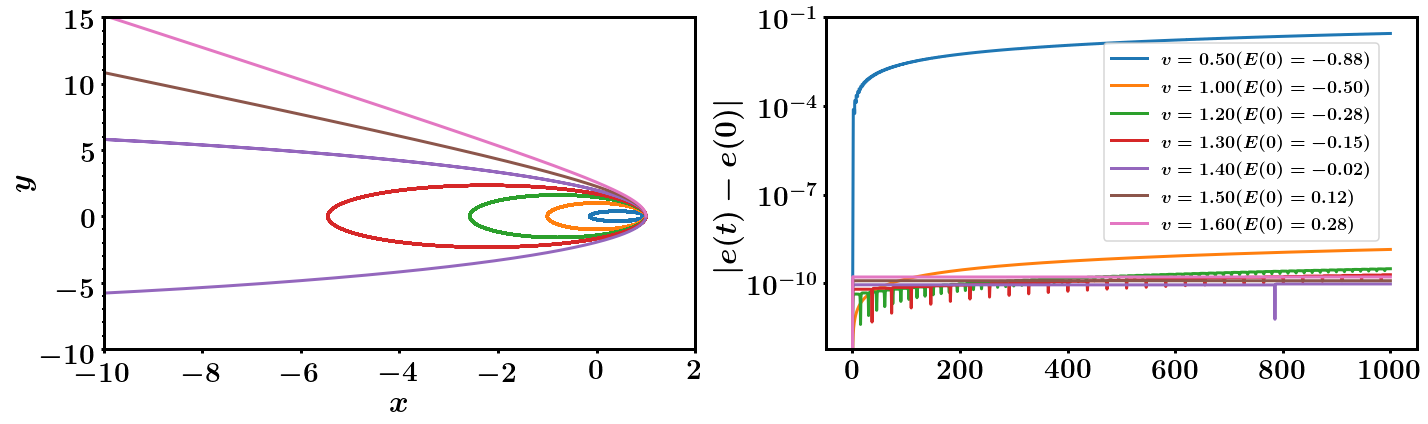

In [113]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, v in enumerate(v_values):
    time, X = data[v]
    x, y = X[:,0], X[:,1]
    e = energy(X, polar=False)
    
    ax = axes[0]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(-10, 2)
    ax.set_ylim(-10, 15)
    ax.plot(x, y)
    
    ax = axes[1]
    ax.set_ylabel(r'$|e(t)-e(0)|$')
    ax.plot(time, np.abs(e-e[0]), label=r'$v={{{:.2f}}} (E(0)={{{:.2f}}})$'.format(v, v**2/2 -1))
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(6e-13, 1e-1)
    ax.legend(loc=1, bbox_to_anchor=(0.95, 0.95), fontsize=18)
    #ax.legend(loc=5, fontsize=18)
    
plt.tight_layout()
plt.savefig('./informe/figures/cartesianas.png')
plt.show()

In [111]:
k = 0.01
method = 'RK4'
v = 1.4
X0 = (1, 0, 0, v)
data_T = {}
T_values = [1000, 10000, 100000]
for T in T_values:
    print(T)
    time, sol = solver(f, k, 0, T, X0, method)
    data_T[T] = [time, sol]

1000
10000
100000


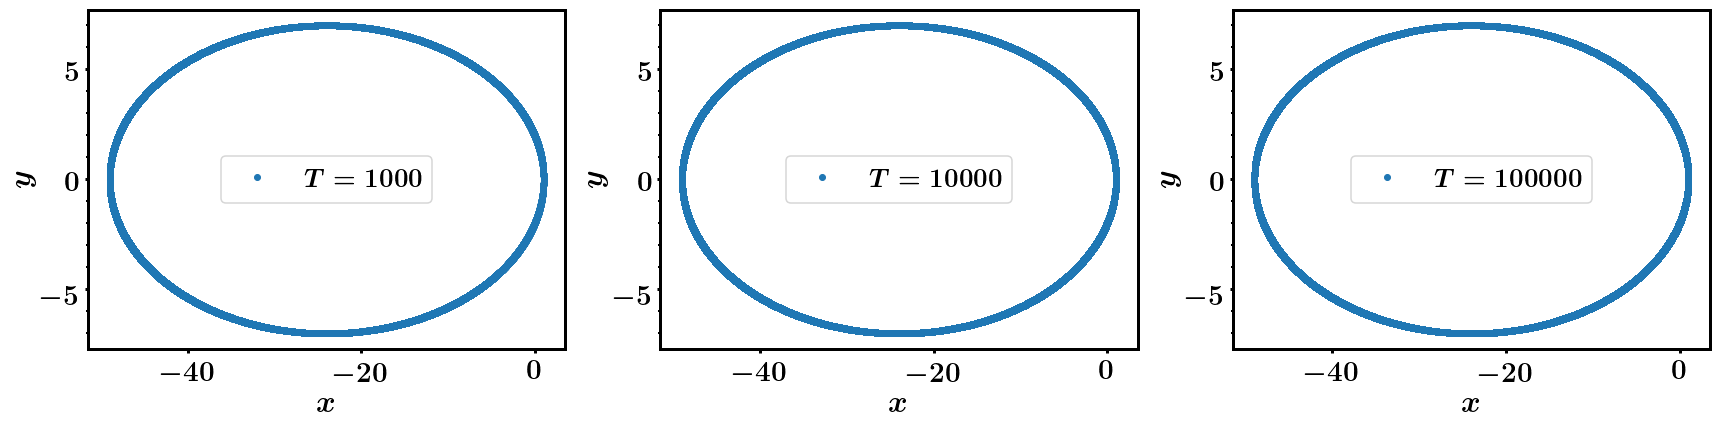

In [112]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, T in enumerate(T_values):
    time, X = data_T[T]
    x, y = X[:,0], X[:,1]
    
    ax = axes[i]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    #ax.set_xlim(-10, 2)
    #ax.set_ylim(-10, 15)
    ax.plot(x, y, 'o', label=r'$T={{{}}}$'.format(T))
    ax.legend()
plt.tight_layout()
plt.savefig('./informe/figures/Ecasi0.png')
plt.show()

In [114]:
def f(X, t):
    
    r, phi, vr, vphi = X
    
    fx = [
        vr,
        vphi,
        -1/r**2,
        0
    ]
    
    return np.array(fx)

def energy(data, polar=True):
    
    if polar:
        r, phi, vr, vphi = data[:,0], data[:,1], data[:,2], data[:,3]
        return 0.5*(vr**2 + r**2 * vphi**2) - 1/r
    x, y, vx, vy = data[:,0], data[:,1], data[:,2], data[:,3]
    return 0.5*(vx**2+vy**2) - 1/np.sqrt(x**2+y**2)

def radius(data):
    return np.sqrt(data[:,0]**2 + data[:,1]**2)
    
T = 100
k = 0.01
method = 'RK4'
vphi = 0.001
vr_values = [0.5, 1, 1.2, 1.3, 1.4, 1.5]
data_pol = {}
last_phis = []
for vr in vr_values:
    print(vr)
    X0 = (5, 0, vr, vphi)
    time, sol = solver(f, k, 0, T, X0, method)
    data_pol[vr] = [time, sol]
    last_phis.append(sol[:,1][-1])

0.5
1
1.2
1.3
1.4
1.5


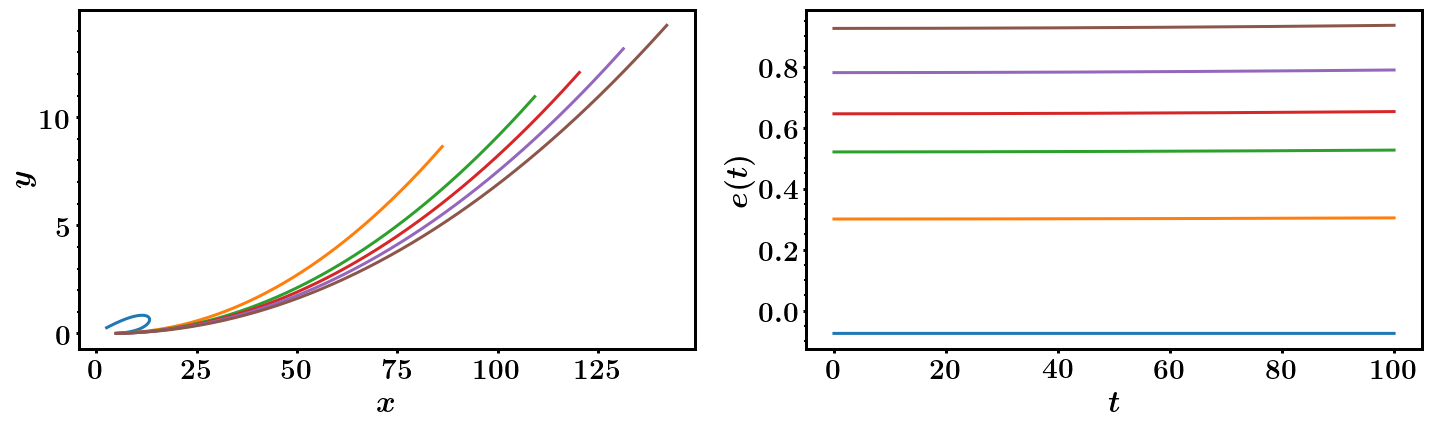

In [115]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, vr in enumerate(vr_values):
    time, X = data_pol[vr]
    r, phi = X[:,0], X[:,1]
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    e = energy(X, polar=True)
    e0 = e[0]
    
    ax = axes[0]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    #ax.set_xlim(-10, 2)
    #ax.set_ylim(-10, 10)
    ax.plot(x, y, label=r'${{{:.2f}}}$'.format(vr))

    ax = axes[1]
    ax.set_ylabel(r'$e(t)$')
    ax.plot(time, e)
    
plt.tight_layout()
plt.show()

In [124]:
def f(X, t):
    
    r, phi, vr, vphi = X
    
    fx = [
        vr,
        vphi,
        -1/r**2,
        0
    ]
    
    return np.array(fx)

def energy(data, polar=True):
    
    if polar:
        r, phi, vr, vphi = data[:,0], data[:,1], data[:,2], data[:,3]
        return 0.5*(vr**2 + r**2 * vphi**2) - 1/r
    x, y, vx, vy = data[:,0], data[:,1], data[:,2], data[:,3]
    return 0.5*(vx**2+vy**2) - 1/np.sqrt(x**2+y**2)

def radius(data):
    return np.sqrt(data[:,0]**2 + data[:,1]**2)
    
T = 1000
k = 0.01
method = 'RK4'
vphi = 0.001
vr_values = np.sqrt(2) + np.logspace(-6, 0, 6)
data_phi = {}
last_phis = []
for vr in vr_values:
    print(vr)
    X0 = (5, 0, vr, vphi)
    time, sol = solver(f, k, 0, T, X0, method)
    data_phi[vr] = [time, sol]
    last_phis.append(sol[:,1][-1])

1.414214562373095
1.4142294113050198
1.414464751016246
1.4181946340786302
1.4773092968211143
2.414213562373095


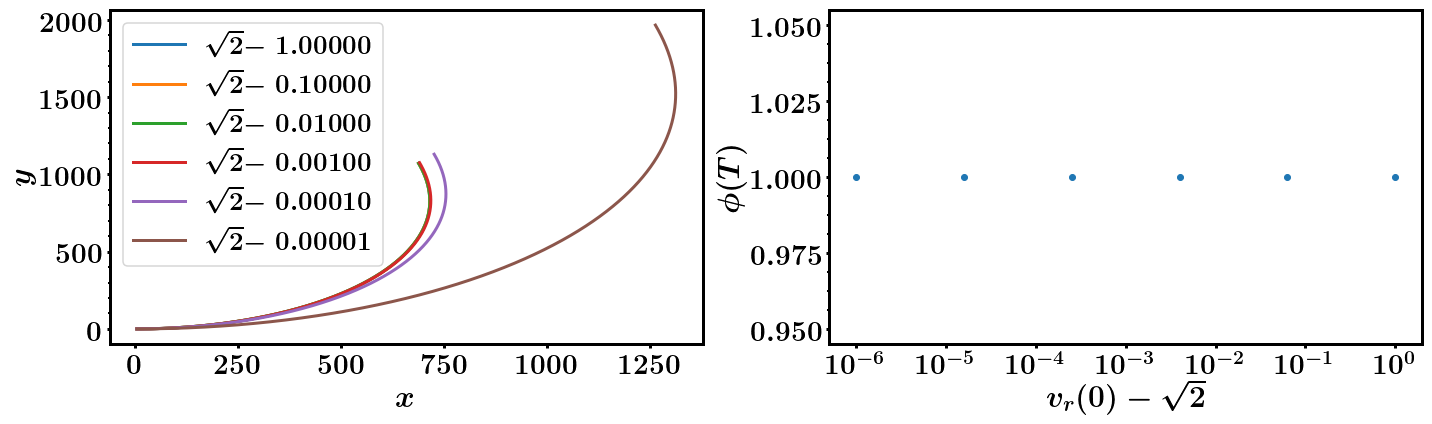

In [136]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, vr in enumerate(vr_values):
    time, X = data_phi[vr]
    r, phi = X[:,0], X[:,1]
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    e = energy(X, polar=True)
    e0 = e[0]
    
    ax = axes[0]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    #ax.set_xlim(-10, 2)
    #ax.set_ylim(-10, 10)
    ax.plot(x, y, label=r'$\sqrt{2} -$'+ r' $ {{{:.5f}}}$'.format(10**(-i)))
    ax.legend(loc='best')
    
ax = axes[1]
ax.set_ylabel(r'$\phi(T)$')
ax.set_xlabel(r'$v_r(0) - \sqrt{2}$')
ax.set_xscale('log')
ax.plot(vr_values-np.sqrt(2), last_phis, 'o')
plt.tight_layout()
plt.savefig('./informe/figures/last_phi.png')
plt.show()

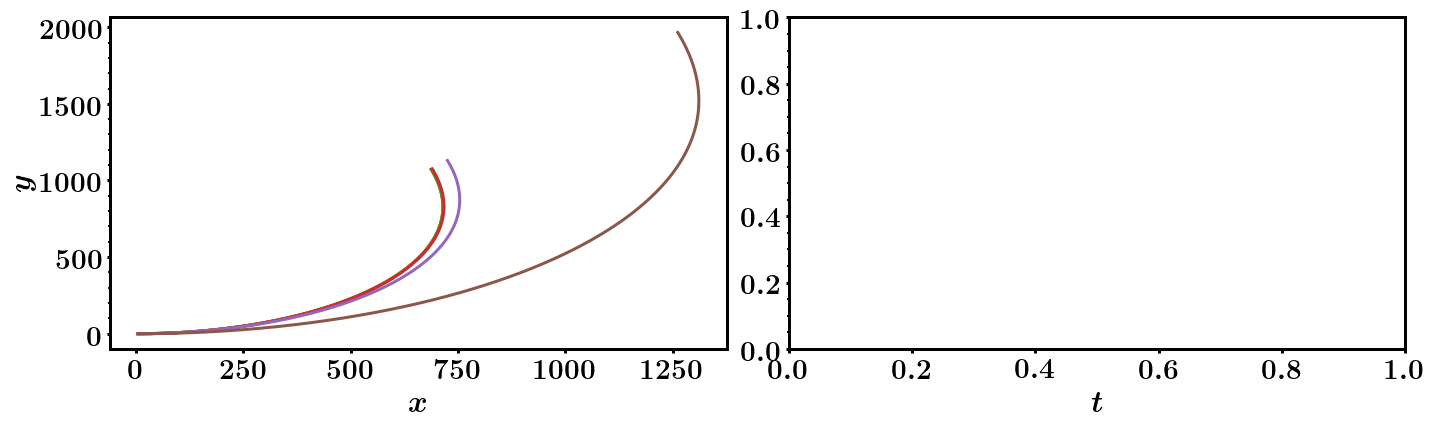

In [126]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$t$')

for i, vr in enumerate(vr_values):
    time, X = data_phi[vr]
    r, phi = X[:,0], X[:,1]
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    e = energy(X, polar=True)
    e0 = e[0]
    
    ax = axes[0]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    #ax.set_xlim(-10, 2)
    #ax.set_ylim(-10, 10)
    ax.plot(x, y, label=r'${{{:.2f}}}$'.format(vr))
    
plt.tight_layout()
plt.show()